In [1]:
import torch
from AdaIN import AdaIN
import matplotlib.pyplot as plt
from PIL import Image


C:\Users\33752\anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
input_image = Image.open("content/Tuebingen_Neckarfront.jpg")
style_image = Image.open("style/vangogh_starry_night.jpg")

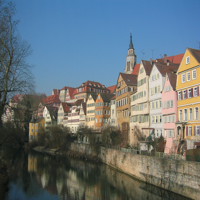

In [4]:
input_image.resize((200, 200))

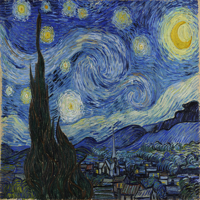

In [5]:
style_image.resize((200, 200))

In [6]:
AdaIN_method = AdaIN().to(device)

In [7]:
out_image = AdaIN_method.transfer_style(input_image, style_image)

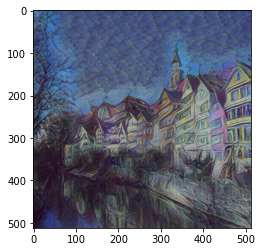

In [8]:
AdaIN_method.display_image(out_image)

In [9]:
r = AdaIN_method.get_content_from_image(input_image, pil=True)

In [10]:
r.shape

torch.Size([1, 512, 64, 64])

In [11]:
v = AdaIN_method.get_style_from_image(style_image, pil=True)

In [12]:
v.shape

torch.Size([1, 1920])